https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

## Install Required Packages

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/")

In [3]:
%%capture 
pip install pyarrow

In [4]:
%%capture 
pip install fastparquet

In [5]:
%%capture
pip install ipywidget

## Import Libraries

In [98]:
import copy
from pathlib import Path
import warnings
import datetime

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,5)

# Set Seeds
np.random.seed(2)
torch.manual_seed(2);

## Import Data
This notebook works the same for all three commodities, first we define the commodity of interest. Choices:
- SUNFLOWER OIL
- MAIZE
- WHEAT

In [15]:
product_type = "SUNFLOWER OIL"
country_filter = "Germany" # 'Germany' 'Denmark' 'Spain' 'Belgium' are in the dataset
date_filter = datetime.date(year = 2018, month = 1, day = 1)
date_end = datetime.date(year = 2022, month = 10, day = 1)

In [16]:
if product_type == "WHEAT":
    trade_data = pd.read_csv("Data/wheat_similar_countries.csv")
    
if product_type == "MAIZE":
    trade_data = pd.read_csv("Data/maize_corn_similar_countries_new.csv")
    
if product_type == "SUNFLOWER OIL":
    trade_data = pd.read_csv("Data/sunflower_oil_similar_countries_new.csv")
    
# Add Time Period steps
trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})

# Make sure that the right product is isolated
products = trade_data["product"].drop_duplicates().to_list()

if product_type == 'SUNFLOWER OIL' or product_type == 'MAIZE':
    product_filter = products[0]

if product_type == 'WHEAT':
    product_filter = products[0]
    
# Add correct labels to the partner and declarent indices
    
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")
declarant_countries = pd.read_csv("Data/declarants.csv", sep = ";")
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')
trade_data = pd.merge(trade_data, declarant_countries, on = ['DECLARANT_codes'], how = 'inner')

# Filter on correct declarant country
trade_data = trade_data[(trade_data["DECLARANT_Labels"] == country_filter)]

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

# Dataframe for total trade data per month which we are forecasting
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total["product"] == product_filter)]

trade_data_total = trade_data_total.set_index("TIME_PERIOD")
trade_data_total = trade_data_total[(trade_data_total.index >= date_filter)]

# Add 2 month rolling average for later validation
trade_data_total['MA2'] = trade_data_total["price"].rolling(window=2).mean()
trade_data_total['MA3'] = trade_data_total["price"].rolling(window=3).mean()

# Import other commodities and use same procedure
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()
oil_data = oil_data.set_index("TIME_PERIOD")
oil_data = oil_data[(oil_data.index >= date_filter) & (oil_data.index <= date_end)]

# Isolate Ukraine - Netherlands Import data for later use
Ukr_Data = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter) & (trade_data_pivot["TIME_PERIOD"] >= date_filter)][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']]
Ukr_Data = Ukr_Data.set_index("TIME_PERIOD")
Ukr_Data = Ukr_Data.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "UKR_QUANTITY"})
trade_data_total['UKR_QUANTITY'] = Ukr_Data['UKR_QUANTITY']
trade_data_total = trade_data_total.fillna(0)

# Import NOAA weather data
weather_data = pd.read_csv("Data/global_temperature_data.csv")
weather_data = weather_data.rename(columns = {"yearmonth" : "TIME_PERIOD"})
weather_data["TIME_PERIOD"] = pd.to_datetime(weather_data["TIME_PERIOD"], format = '%Y%m').dt.date
weather_data = weather_data.set_index("TIME_PERIOD")
weather_data = weather_data[(weather_data.index >= date_filter) & (weather_data.index <= date_end)]

weather_ukr = weather_data[weather_data['weather_countryname'] == 'Ukraine']
weather_fr = weather_data[weather_data['weather_countryname'] == 'France']
weather_ger = weather_data[weather_data['weather_countryname'] == 'Germany']

# Merge data to one frame 
data = trade_data_total.merge(oil_data, on = 'TIME_PERIOD')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]

data['UKRMA3'] = trade_data_total["UKR_QUANTITY"].rolling(window=3).mean()

data['avgTempUkr'] = weather_ukr["AVG_TAVG"] / 10
data['avgTempFr'] = weather_fr["AVG_TAVG"] / 10
data['avgTempGer'] = weather_ger["AVG_TAVG"] / 10


Add date variables

In [130]:
data['product'] = data['product'].astype(str)
data['timeidx'] = range(len(data))

data['year'] = pd.DatetimeIndex(data.index).year.astype(str).astype('category')
data['month'] = pd.DatetimeIndex(data.index).month.astype(str).astype('category')

test_split = datetime.date(year = 2021, month = 1, day = 1)
training_data = data[(data.index < test_split)]

# Add MA2 
data['NGAS_EUR_MA2'] = data["NGAS_EUR"].rolling(window=2).mean()
data['CRUDE_PETRO_MA2'] = data["CRUDE_PETRO"].rolling(window=2).mean()

In [131]:
data.tail()

,product,OBS_VALUE_QUANTITY_TON,OBS_VALUE_VALUE_1000EURO,price,MA2,MA3,UKR_QUANTITY,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,...,SILVER,UKRMA3,avgTempUkr,avgTempFr,avgTempGer,timeidx,year,month,NGAS_EUR_MA2,CRUDE_PETRO_MA2
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2022-06-01,15121191,27696.1,44275.67,1.598625,1.612458,1.543778,373.3,116.80,120.08,115.73,...,21.56,463.400000,20.945122,19.734634,18.873799,53,2022,6,31.365,113.450
2022-07-01,15121191,22225.4,34104.15,1.534467,1.566546,1.586461,242.3,105.08,108.92,106.48,...,19.08,517.233333,21.286160,22.094888,19.872343,54,2022,7,42.445,110.940
2022-08-01,15121191,20333.1,34342.93,1.689016,1.611742,1.607369,99.9,95.97,98.60,97.75,...,19.72,238.500000,22.452331,22.188199,20.880088,55,2022,8,60.685,100.525
2022-09-01,15121191,14174.9,23144.88,1.632807,1.660912,1.618764,39.9,88.22,90.16,90.63,...,18.94,127.366667,13.617683,17.065057,13.996936,56,2022,9,64.570,92.095
2022-10-01,15121191,17477.9,26405.28,1.510781,1.571794,1.610868,150.4,90.33,93.13,90.59,...,19.43,96.733333,11.385827,15.956502,13.011634,57,2022,10,49.060,89.275


## Set-up Model

Notes:
- If validating: max_prediction_length gives the number of months to forecast at the end of the war
- If out of sample forecast: max_prediction length should be set to 6
- trainig_cutoff should be set to the upper value if validating, otherwise it is the length of the reduced dataset - months in to war speaks for itself, if we are less far into the war we have less training data and shoul drop some months 

In [118]:
max_prediction_length = 3
max_encoder_length = 12

# Set to len(data) - max_prediction_length if we want to assess in sample loss
training_cutoff = len(data) - max_prediction_length
target_feat = "price" #price, MA2

tradingIntensity = "Moderate"
energyPrices = "Low"

# For in sample validation, set to end of war (7) and control the forecast window with max_prediction_length
months_into_war = 7
months_to_drop = 7 - months_into_war

if months_to_drop == 0:
    reduced_data_set = data.copy()

else:
    reduced_data_set = data.head(- months_to_drop)

# Uncomment if not validating
# training_cutoff = len(reduced_data_set) 


if target_feat == "MA2":
    reduced_data_set = reduced_data_set.iloc[3:]

if target_feat == "MA6":
    reduced_data_set = reduced_data_set.iloc[6:]

    
training = TimeSeriesDataSet(
    # SWITCHED FROM DATA
    reduced_data_set[lambda x: x.timeidx <= training_cutoff],
    time_idx="timeidx",
    target=target_feat,
    group_ids=["product"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product"],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals= [
        "timeidx", 
        "NGAS_EUR", 
        "CRUDE_PETRO", 
        "UKR_QUANTITY"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        target_feat,
        "OBS_VALUE_QUANTITY_TON",
        "OBS_VALUE_VALUE_1000EURO",
        "MAIZE",
        "WHEAT_US_HRW",
        "SUNFLOWER_OIL",
    ],
    target_normalizer=GroupNormalizer(
        # Earlier GroupNormalizer
        groups=["product"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series\
validation = TimeSeriesDataSet.from_dataset(training, reduced_data_set, predict=True, stop_randomization=True)

# SWITCHED FROM DATA
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


## Hyperparameter Tuning

In [88]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=300,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=60),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)
print(study.best_trial.value);

[I 2023-02-15 14:01:06,580] A new study created in memory with name: no-name-52f9184f-9b75-44fb-b45d-e84c10077594
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 14:01:15,032] Trial 0 finished with value: 0.10729993134737015 and parameters: {'gradient_clip_val': 0.06576799678882617, 'hidden_size': 124, 'dropout': 0.1287945964695582, 'hidden_continuous_size': 10, 'attention_head_size': 4, 'learning_rate': 0.003465044915072982}. Best is trial 0 with value: 0.10729993134737015.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 14:01:23,414] Trial 1 finished with value: 0.011033368296921253 and parameters: {'gradient_clip_val': 0.03295895656252136, 'hidden_size': 78, 'dropout': 0.12047083090699387, 'hidden_contin

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/optuna_test/trial_5'

## Save Best Results

In [ ]:
res = study.best_trial.params


gradient_clip_val = res['gradient_clip_val']
hidden_size = res['hidden_size']
dropout = res['dropout']
hidden_continuous_size = res['hidden_continuous_size']
attention_head_size = res['attention_head_size']
learning_rate = res['learning_rate']

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs=400,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
#     fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [42]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_tft = tft


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 924   
4  | static_variable_selection          | VariableSelectionNetwork        | 18.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 70.5 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 31.1 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 9.9 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 9.9 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 9.9 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [43]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [44]:
# raw_predictions

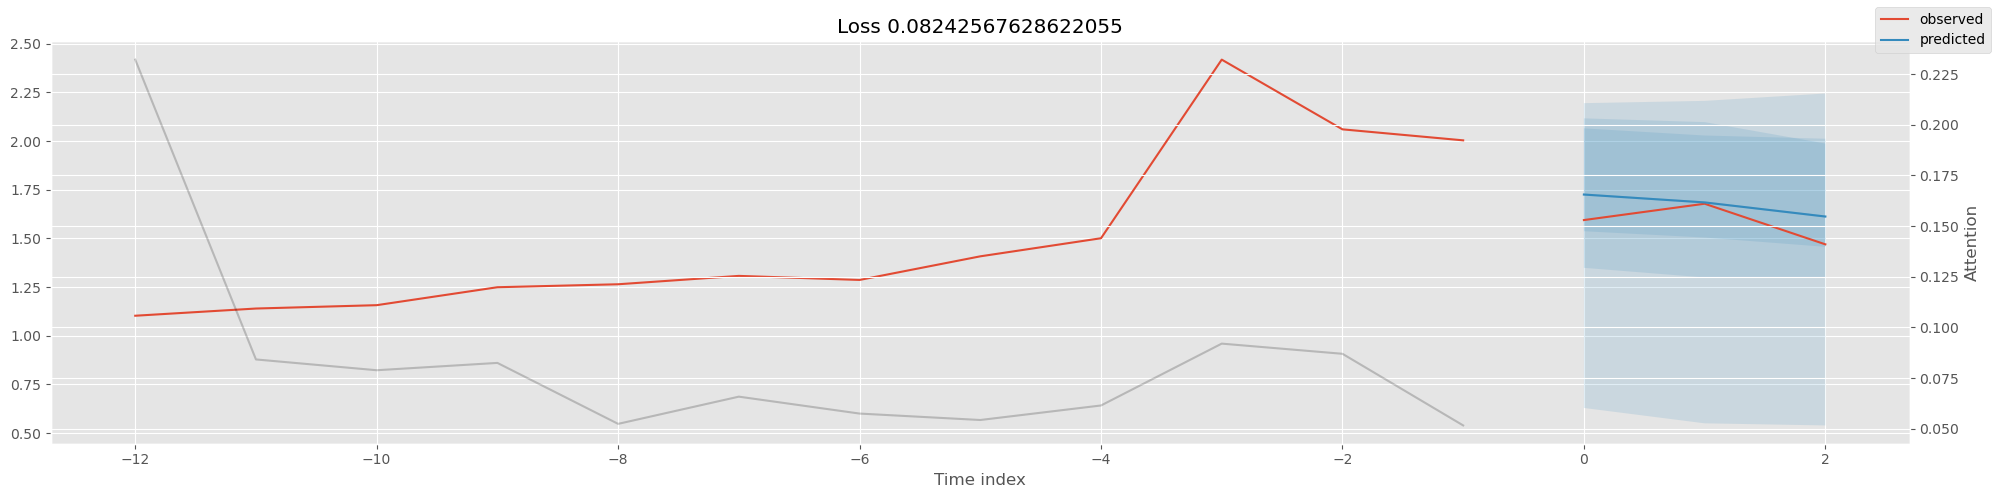

In [45]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);


## Plotter for In-Sample Validation

In [46]:
# def quantile_loss(quantiles, target):
#     q_list = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    
#     loss = 0 
    
#     for q in range(len(q_list)):
#         preds = quantiles[q]
#         for i in range(len(preds)):
# #             print(q_list[q], max(q_list[q] * (target[i]-preds[i]), (1-q_list[q]) * (preds[i]-target[i])))
#             loss += max(q_list[q] * (target[i]-preds[i]), (1-q_list[q]) * (preds[i]-target[i]))
#     print(loss / len(q_list))

# print(raw_predictions)

data_plotter = data.copy()
data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
    
MA2_val = list(data_plotter['MA2'].tail(max_prediction_length))
price_val = list(data_plotter['price'].tail(max_prediction_length))
    
y_pred = best_tft.to_quantiles(raw_predictions)
target =  torch.FloatTensor(price_val)
    
# print(best_tft.loss(best_tft.to_quantiles(raw_predictions), torch.FloatTensor(price_val)))
    
print(y_pred)
print(target)
print(torch.mean(QuantileLoss().loss(y_pred, target)))
# def quantile_loss(quantiles, target):
#     best_tft.loss(quantiles, target)
    

tensor([[[0.6293, 1.3487, 1.5366, 1.7249, 2.0646, 2.1160, 2.1940],
         [0.5504, 1.2991, 1.5042, 1.6844, 2.0279, 2.0966, 2.2057],
         [0.5396, 1.3006, 1.4565, 1.6120, 2.0114, 1.9865, 2.2436]]])
tensor([1.5939, 1.6777, 1.4692])
tensor(0.0824)


Quantile Loss =  0.082
MAPE MA2 =  0.032
MAPE price =  0.056


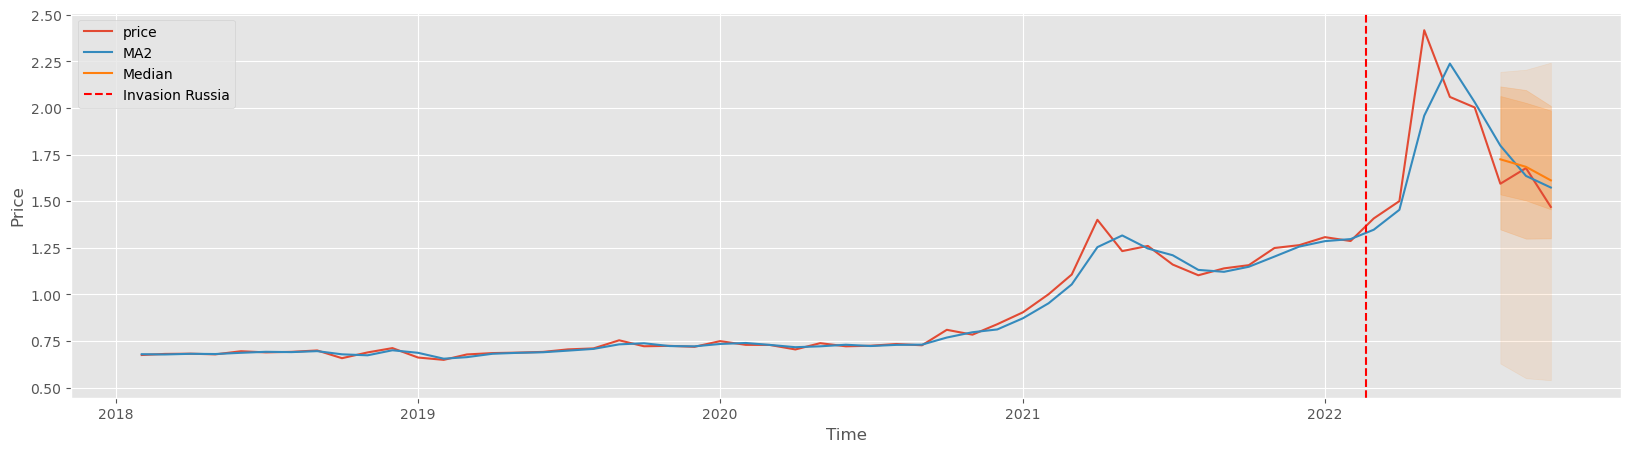

In [47]:
def forecaster_plotter(raw_dat, raw_predictions, data):
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
                
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
    
    MA2_val = list(data_plotter['MA2'].tail(max_prediction_length))
    price_val = list(data_plotter['price'].tail(max_prediction_length))
    
    MAPE_MA2 = mean_absolute_percentage_error(q5, MA2_val)
    MAPE_price = mean_absolute_percentage_error(q5, price_val)
    y_pred = best_tft.to_quantiles(raw_dat)
    target =  torch.FloatTensor(price_val)
    
    print('Quantile Loss = ', "{:.3f}".format(torch.mean(QuantileLoss().loss(y_pred, target))))
    print('MAPE MA2 = ', "{:.3f}".format(MAPE_MA2))
    print('MAPE price = ', "{:.3f}".format(MAPE_price))

    index_list = list(reduced_data_set.index.values)
    used_list = index_list[-max_prediction_length:]
    
    ax = data_plotter[(data_plotter.index > date_filter)][["price", "MA2"]].plot()
    plt.fill_between(used_list, q02, q98, alpha = 0.1, color = 'tab:orange')
    plt.fill_between(used_list, q10, q90, alpha = 0.2, color = 'tab:orange')
    plt.fill_between(used_list, q25, q75, alpha = 0.2, color = 'tab:orange')

    plt.plot(used_list, q5, color = 'tab:orange', label = 'Median')
    plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

forecaster_plotter(raw_predictions, raw_predictions['prediction'], data)   

## Out-of-Sample Prediction

In [48]:
averageBegin = datetime.date(year = 2020, month = 2, day = 1)
averageEnd = datetime.date(year = 2022, month = 2, day = 1)

energyPrices = "High"

twoYearAverageGas = data[(data.index >= averageBegin) & (data.index <= averageEnd)]["NGAS_EUR"].mean()
twoYearAverageOil = data[(data.index >= averageBegin) & (data.index <= averageEnd)]["CRUDE_PETRO"].mean()

if energyPrices == "Low":
    simDataGas = [0.2 * twoYearAverageGas] * max_prediction_length
    simDataOil = [0.2 * twoYearAverageOil] * max_prediction_length
    
if energyPrices == "Moderate":
    simDataGas = [1.5 * twoYearAverageGas] * max_prediction_length
    simDataOil = [1.5 * twoYearAverageOil] * max_prediction_length
    
if energyPrices == "High":
    simDataGas = [5 * twoYearAverageGas] * max_prediction_length
    simDataOil = [2 * twoYearAverageOil] * max_prediction_length
    
if energyPrices == "Very High":
    simDataGas = [4 * twoYearAverageGas] * max_prediction_length
    simDataOil = [4 * twoYearAverageOil] * max_prediction_length
    
if energyPrices == "Trend":
    simDataGas = [5.5 * twoYearAverageGas] + [6 * twoYearAverageGas] + [6.5 * twoYearAverageGas] + [7 * twoYearAverageGas] + [7.5 * twoYearAverageGas] + [8 * twoYearAverageGas]
    simDataOil = [1.7 * twoYearAverageOil] + [1.8 * twoYearAverageOil] + [2 * twoYearAverageOil] + [2.2 * twoYearAverageOil] + [2.4 * twoYearAverageOil] + [2.6 * twoYearAverageOil]

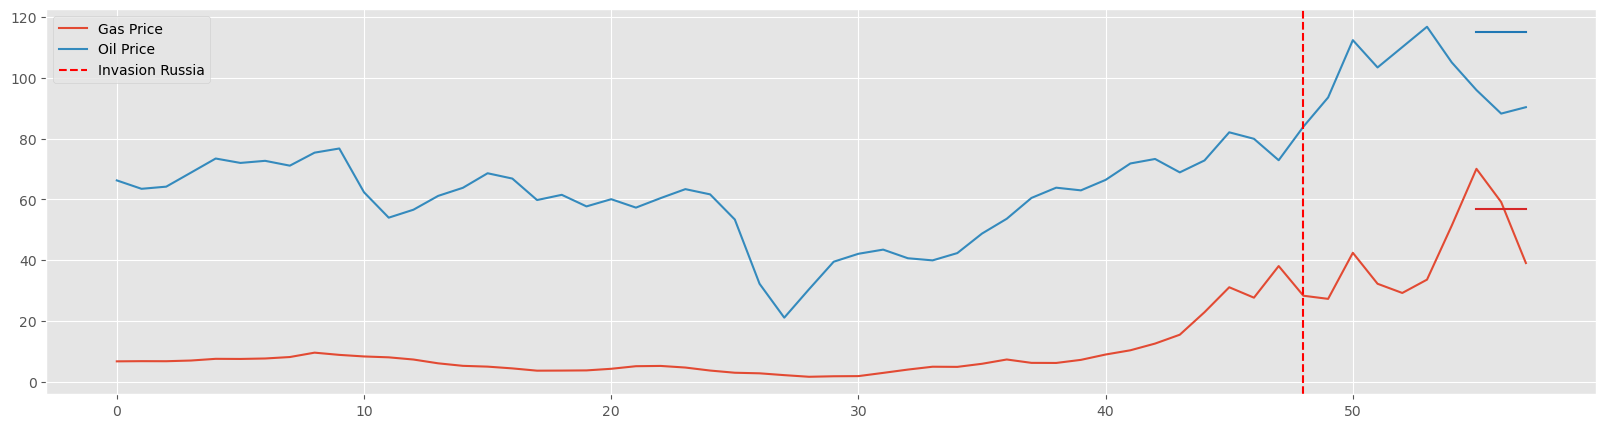

In [49]:
# display(data.tail(10))
x = np.arange(len(data))
x_extr = np.arange(48 + months_into_war, 48 + months_into_war + max_prediction_length)
plt.plot(x, data["NGAS_EUR"], label = 'Gas Price')
plt.plot(x, data["CRUDE_PETRO"], label = 'Oil Price')
plt.plot(x_extr, simDataGas, color = 'tab:red')
plt.plot(x_extr, simDataOil, color = 'tab:blue')
plt.axvline(48, color = 'red', linestyle = '--', label = 'Invasion Russia')
plt.legend();

In [50]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.timeidx > x.timeidx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.timeidx == x.timeidx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.index + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["timeidx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["timeidx"] += encoder_data["timeidx"].max() + 1 - decoder_data["timeidx"].min()\

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
decoder_data["year"] = decoder_data.date.dt.year.astype(str).astype("category")  # categories have be strings

for i in range(max_prediction_length):
    replaceIndex = i
    
    replaceValueGas = simDataGas[replaceIndex]
    replaceValueOil = simDataOil[replaceIndex]
        
    decoder_data.loc[replaceIndex,'NGAS_EUR'] = replaceValueGas
    decoder_data.loc[replaceIndex,'CRUDE_PETRO'] = replaceValueOil

# # combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

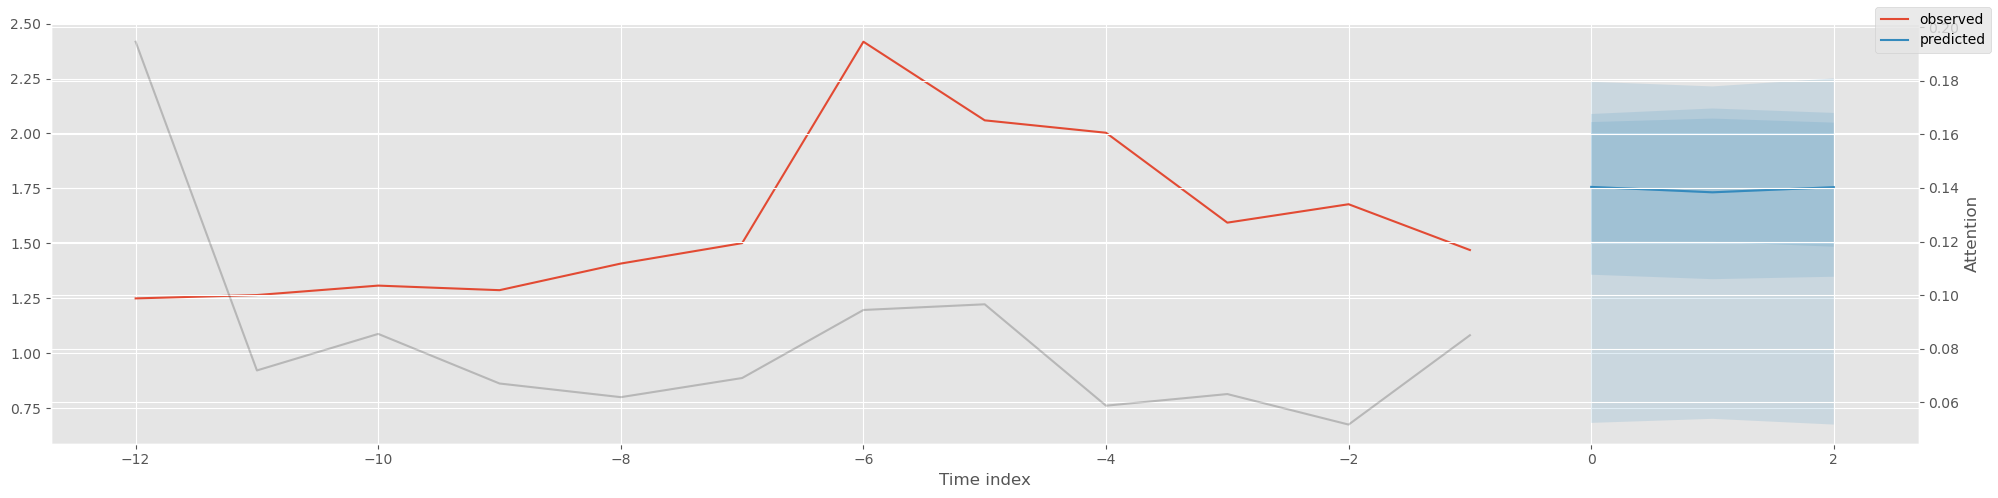

In [51]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False);    

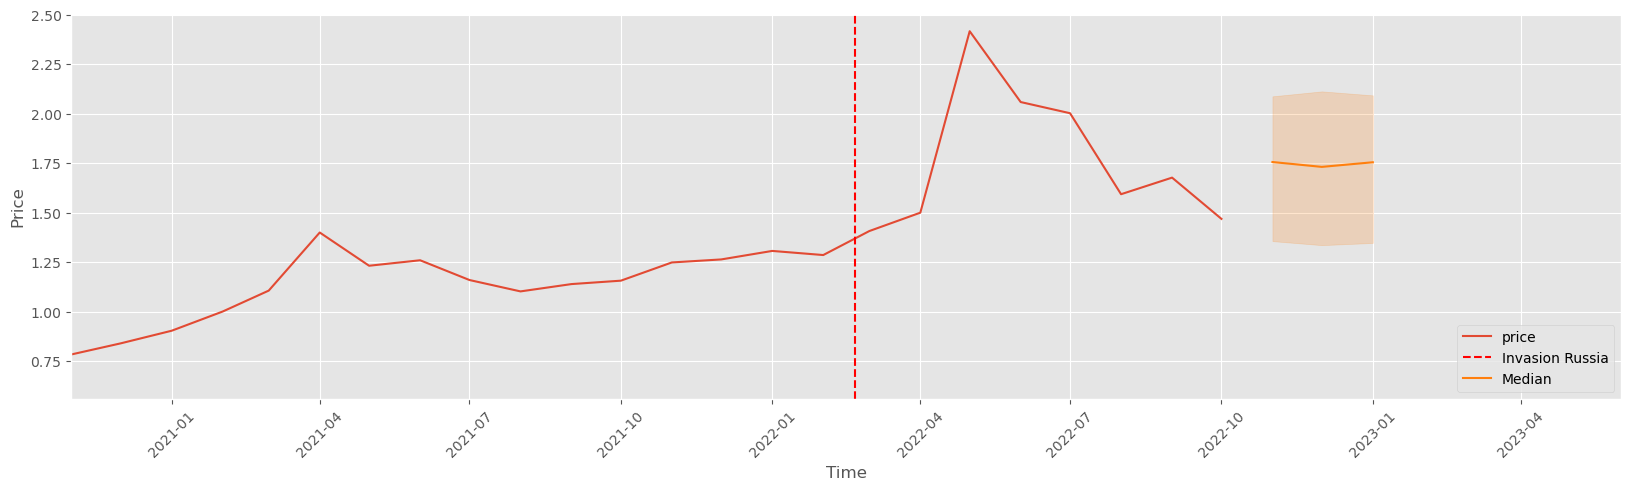

In [52]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

def sim_forecaster_plotter(raw_predictions, data, prediction_length):
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
                
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - prediction_length)
    
    last_data = data[lambda x: x.timeidx == x.timeidx.max()]
    
    # Get first month of forecast window
    first_month  = int(last_data["month"]) + 1 - months_to_drop
    first_year = int(last_data["year"])
    
    index_list = list(data_plotter.index.values)
    
    used_list_new = []
    
    for i in range(prediction_length):
        current_month = first_month + i
        current_year = first_year
        
        if current_month > 12:
            current_month = current_month - 12
            current_year = first_year + 1
        
        used_list_new.append(datetime.date(year = current_year, month = current_month, day = 1))
            
    used_list = index_list[-max_prediction_length:]
    
    ax = data_plotter[(data_plotter.index > date_filter)][[target_feat]].plot()
#     plt.fill_between(used_list_new, q02, q98, alpha = 0.2, color = 'tab:orange')
#     plt.fill_between(used_list_new, q25, q75, alpha = 0.2, color = 'tab:orange')
    plt.fill_between(used_list_new, q10, q90, alpha = 0.2, color = 'tab:orange')

    plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')
    plt.xlim([datetime.date(2020, 11, 1), datetime.date(2023, 6, 1)]);
    plt.xticks(rotation = 45)
    plt.plot(used_list_new, q5, color = 'tab:orange', label = 'Median')
#     plt.title('Average Import Price Forecast: ' + product_type)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc = 'lower right')
    
sim_forecaster_plotter(new_raw_predictions['prediction'], data, max_prediction_length)   

In [53]:
averageBegin = datetime.date(year = 2020, month = 2, day = 1)
averageEnd = datetime.date(year = 2022, month = 2, day = 1)

twoYearAverage = data[(data.index >= averageBegin) & (data.index <= averageEnd)]["UKR_QUANTITY"].mean()

max_quantity = data["UKR_QUANTITY"].max()
very_high_peak = max_quantity * 1.5
high_peak = max_quantity * 0.75
moderate_peak = max_quantity * 0.5

if tradingIntensity == "Low":
    simData = [0] * max_prediction_length
    
if tradingIntensity == "Moderate":
    simData = [moderate_peak / 2] + [moderate_peak] * (max_prediction_length - 1)
    
if tradingIntensity == "High":
    simData = [high_peak / 2] + [high_peak] * (max_prediction_length - 1)
    
if tradingIntensity == "Very High":
    simData = [very_high_peak / 2] + [very_high_peak] * (max_prediction_length - 1)
    

In [54]:
def situation_simulator(energyPrices, tradingIntensity):
    last_data = data[lambda x: x.timeidx == (x.timeidx.max())]
    lastGas = last_data["NGAS_EUR"].item()
    lastOil = last_data["CRUDE_PETRO"].item()
    lastQuant = last_data["UKR_QUANTITY"].item()
    
    max_quantity = data[(data.index >= datetime.date(year = 2020, month = 2, day = 1)) & (data.index <= datetime.date(year = 2022, month = 2, day = 1))]["UKR_QUANTITY"].mean()
    max_GasPrice = data["NGAS_EUR"].max()
    max_OilPrice = data["CRUDE_PETRO"].max()
    
    very_high_peak_trade = max_quantity * 2
    high_peak_trade = max_quantity * 1.5
    moderate_peak_trade = max_quantity * 1
    
    very_high_peak_gas = max_GasPrice * 1.5
    high_peak_gas = max_GasPrice * 0.75
    moderate_peak_gas = max_GasPrice * 0.5
    low_peak_gas = max_GasPrice * 0.2
    
    very_high_peak_oil = max_OilPrice * 1.5
    high_peak_oil = max_OilPrice * 0.75
    moderate_peak_oil = max_OilPrice * 0.5
    low_peak_oil = max_OilPrice * 0.2

    
    if tradingIntensity == "Low":
        simDataTrade = [0] * max_prediction_length
    
    if tradingIntensity == "Moderate":
        difTrade = moderate_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [moderate_peak_trade] * (max_prediction_length - 1)

    if tradingIntensity == "High":
        difTrade = high_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [high_peak_trade] * (max_prediction_length - 1)

    if tradingIntensity == "Very High":
        difTrade = very_high_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [very_high_peak_trade] * (max_prediction_length - 1)
        
        
    if energyPrices == "Low":
        difGas = low_peak_gas - lastGas
        difOil = low_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [low_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [low_peak_oil] * (max_prediction_length - 1)
    
    if energyPrices == "Moderate":
        difGas = moderate_peak_gas - lastGas
        difOil = moderate_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [moderate_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [moderate_peak_oil] * (max_prediction_length - 1)

    if energyPrices == "High":
        difGas = high_peak_gas - lastGas
        difOil = high_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [high_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [high_peak_oil] * (max_prediction_length - 1)

    if energyPrices == "Very High":
        difGas = very_high_peak_gas - lastGas
        difOil = very_high_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [very_high_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [very_high_peak_oil] * (max_prediction_length - 1)
            
    return simDataGas, simDataOil, simDataTrade    
    

ValueError: x and y must have same first dimension, but have shapes (7,) and (4,)

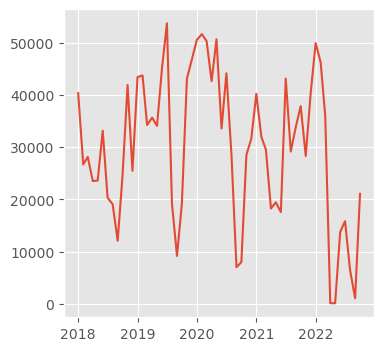

In [55]:
gasL, oilL, tradeL = situation_simulator("Low", "Low")
gasM, oilM, tradeM = situation_simulator("Moderate", "Moderate")
gasH, oilH, tradeH = situation_simulator("High", "High")
gasVH, oilVH, tradeVH = situation_simulator("Very High", "Very High")

final_oil_price = oil_data.tail(1)['CRUDE_PETRO'].item()
final_gas_price = oil_data.tail(1)['NGAS_EUR'].item()
final_trade = data.tail(1)['UKR_QUANTITY'].item()

# display(data.tail())
gasL = [final_gas_price] + gasL
gasM = [final_gas_price] + gasM
gasH = [final_gas_price] + gasH
gasVH = [final_gas_price] + gasVH

# display(data.tail())
oilL = [final_oil_price] + oilL
oilM = [final_oil_price] + oilM
oilH = [final_oil_price] + oilH
oilVH = [final_oil_price] + oilVH

# display(data.tail())
tradeL = [final_trade] + tradeL
tradeM = [final_trade] + tradeM
tradeH = [final_trade] + tradeH
tradeVH = [final_trade] + tradeVH

plt.rcParams["figure.figsize"] = (4,4)

x = np.arange(len(data))
x_extr = pd.date_range(datetime.date(year=2022, month=9, day=1), periods=7, freq = 'm').tolist()
plt.plot(data.index, data["UKR_QUANTITY"], label = 'Trade Intensity')
# plt.plot(data.index, data["CRUDE_PETRO"], label = 'Oil Price')
# plt.plot(data.index, data["NGAS_EUR"], label = 'Gas Price')

# plt.plot(x_extr, gasL, color = 'tab:blue', linestyle = '--')
# plt.plot(x_extr, gasM, color = 'tab:blue', linestyle = '--')
# plt.plot(x_extr, gasH, color = 'tab:blue', linestyle = '--')
# plt.plot(x_extr, gasVH, color = 'tab:blue', linestyle = '--')

# plt.plot(x_extr, oilL, color = 'tab:red', linestyle = '--')
# plt.plot(x_extr, oilM, color = 'tab:red', linestyle = '--')
# plt.plot(x_extr, oilH, color = 'tab:red', linestyle = '--')
# plt.plot(x_extr, oilVH, color = 'tab:red', linestyle = '--')

plt.plot(x_extr, tradeL, color = 'tab:blue', linestyle = '--')
plt.plot(x_extr, tradeM, color = 'tab:blue', linestyle = '--')
plt.plot(x_extr, tradeH, color = 'tab:blue', linestyle = '--')
plt.plot(x_extr, tradeVH, color = 'tab:blue', linestyle = '--')

# last_data = data[lambda x: x.timeidx == (x.timeidx.max() - 6)]
# plt.scatter(data.timeidx.max() - 6, last_data["NGAS_EUR"].item())
plt.xlim([datetime.date(2019, 11, 1), datetime.date(2023, 6, 1)]);
# plt.ylim(0,20000)
plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Start War')
plt.xticks(rotation = 45)
plt.xlabel('Time')
plt.ylabel('Quantity [Ton]')
# plt.axvline(55, color = 'green', linestyle = '--', label = 'Start Forecast')
plt.legend();

In [57]:
plt.rcParams["figure.figsize"] = (4,4)

@widgets.interact(
    energyPrices=['Low', 'Moderate', 'High', 'Very High'], 
    tradingIntensity = ['Low', 'Moderate', 'High', 'Very High'])
def plotter(energyPrices, tradingIntensity):
    simDataGas, simDataOil, simDataTrade = situation_simulator(energyPrices, tradingIntensity)

    encoder_data = data[lambda x: x.timeidx > x.timeidx.max() - max_encoder_length]

    # select last known data point and create decoder data from it by repeating it and incrementing the month
    # in a real world dataset, we should not just forward fill the covariates but specify them to account
    # for changes in special days and prices (which you absolutely should do but we are too lazy here)
    last_data = data[lambda x: x.timeidx == x.timeidx.max()]
    decoder_data = pd.concat(
        [last_data.assign(date=lambda x: x.index + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
        ignore_index=True,
    )

    # add time index consistent with "data"
    decoder_data["timeidx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
    decoder_data["timeidx"] += encoder_data["timeidx"].max() + 1 - decoder_data["timeidx"].min()

    # adjust additional time feature(s)
    decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
    decoder_data["year"] = decoder_data.date.dt.year.astype(str).astype("category")  # categories have be strings

    for i in range(max_prediction_length):
        replaceIndex = i

        replaceValueGas = simDataGas[replaceIndex]
        replaceValueOil = simDataOil[replaceIndex]
        replaceValueTrade = simDataTrade[replaceIndex]
        
        if target_feat == "price":
            replaceGas = "NGAS_EUR"
            replaceOil = "CRUDE_PETRO"
        
        if target_feat == "MA2":
            replaceGas = "NGAS_EUR_MA2"
            replaceOil = "CRUDE_PETRO_MA2"

        decoder_data.loc[replaceIndex, replaceGas] = replaceValueGas
        decoder_data.loc[replaceIndex, replaceOil] = replaceValueOil
        decoder_data.loc[replaceIndex, 'UKR_QUANTITY'] = replaceValueTrade
        
    # combine encoder and decoder data
    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    
    new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)        
    sim_forecaster_plotter(new_raw_predictions['prediction'], data, max_prediction_length)       

interactive(children=(Dropdown(description='energyPrices', options=('Low', 'Moderate', 'High', 'Very High'), v…

## Variables Importance and Attention

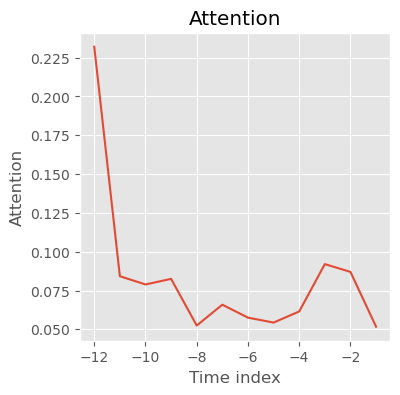

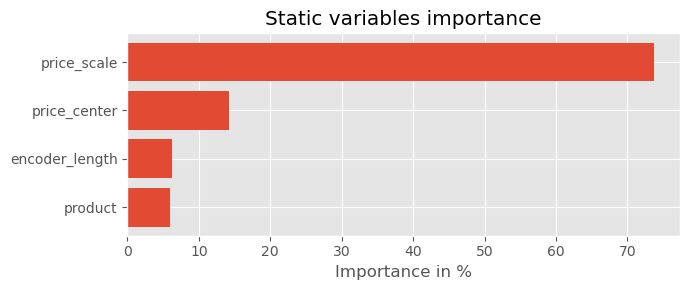

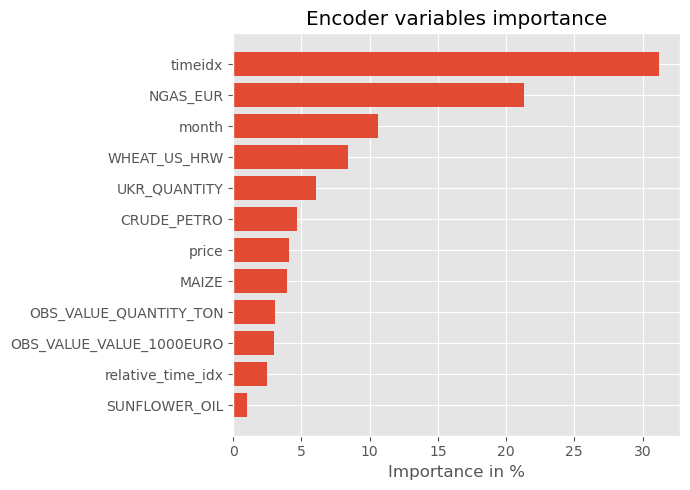

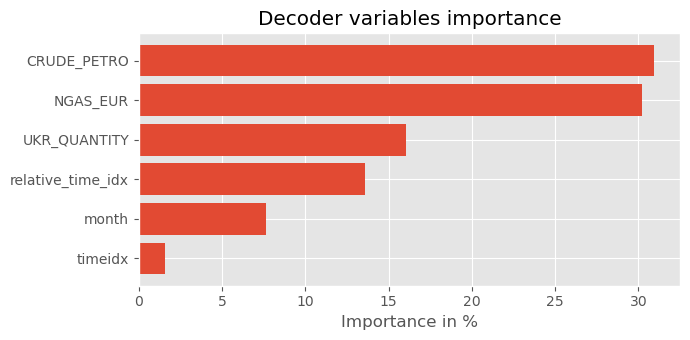

In [58]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation);

In [59]:
interpretation

{'attention': tensor([0.2321, 0.0842, 0.0789, 0.0825, 0.0524, 0.0659, 0.0575, 0.0543, 0.0615,
         0.0920, 0.0870, 0.0517]),
 'static_variables': tensor([0.0588, 0.0620, 0.1424, 0.7368]),
 'encoder_variables': tensor([0.1065, 0.3119, 0.2134, 0.0471, 0.0611, 0.0246, 0.0410, 0.0310, 0.0298,
         0.0399, 0.0839, 0.0099]),
 'decoder_variables': tensor([0.0764, 0.0156, 0.3022, 0.3095, 0.1605, 0.1359]),
 'encoder_length_histogram': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 'decoder_length_histogram': tensor([0, 0, 1])}

In [60]:
# plt.rcParams["figure.figsize"] = (25,2)
# plt.title('gradient_clip_val_list')
# plt.plot(gradient_clip_val_list)
# plt.show()
# plt.title('hidden_size_list')
# plt.plot(hidden_size_list)
# plt.show()
# plt.title('dropout_list')
# plt.plot(dropout_list)
# plt.show()
# plt.title('hidden_continuous_size_list')
# plt.plot(hidden_continuous_size_list)
# plt.show()
# plt.title("attention_head_size_list")
# plt.plot(attention_head_size_list)
# plt.show()
# plt.title("learning_rate_list")
# plt.plot(learning_rate_list);

In [ ]:
# print(study.best_trial.value)

## Sensitivity Analysis In-Sample Encoder Length

In [138]:
max_prediction_length_list = [6,5,4,3,2]

QLoss_log = []
Hyperparameter_log = []
raw_data_log = []

for prediction_length in max_prediction_length_list:
    print("Max Prediction Length: ", prediction_length)
    max_prediction_length = prediction_length
    max_encoder_length = 12

    # Set to len(data) - max_prediction_lenth if we want to assess in sample loss
    training_cutoff = len(data)  - max_prediction_length
    target_feat = "price" #price, MA2

    # For in sample validation, set to end of war (7) and control the forecast window with max_prediction_length
    months_into_war = 7
    months_to_drop = 7 - months_into_war

    if months_to_drop == 0:
        reduced_data_set = data.copy()

    else:
        reduced_data_set = data.head(- months_to_drop)

    training = TimeSeriesDataSet(
        # SWITCHED FROM DATA
        reduced_data_set[lambda x: x.timeidx <= training_cutoff],
        time_idx="timeidx",
        target=target_feat,
        group_ids=["product"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["product"],
        static_reals=[],
        time_varying_known_categoricals=["month"],
        time_varying_known_reals= [
            "timeidx", 
            "NGAS_EUR",
            "CRUDE_PETRO", 
            "UKR_QUANTITY",
        ],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            target_feat,
            "OBS_VALUE_QUANTITY_TON",
            "OBS_VALUE_VALUE_1000EURO",
            "MAIZE",
            "WHEAT_US_HRW",
            "SUNFLOWER_OIL",
        ],
        target_normalizer=GroupNormalizer(
            # Earlier GroupNormalizer
            groups=["product"], transformation="softplus"
        ),  # use softplus and normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True
    )

    # create validation set (predict=True) which means to predict the last max_prediction_length points in time
    # for each series\
    validation = TimeSeriesDataSet.from_dataset(training, reduced_data_set, predict=True, stop_randomization=True)

    # SWITCHED FROM DATA
    # validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 128  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
    
    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=300,
        max_epochs=50,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=60),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )
    
    res = study.best_trial.params

    gradient_clip_val = res['gradient_clip_val']
    hidden_size = res['hidden_size']
    dropout = res['dropout']
    hidden_continuous_size = res['hidden_continuous_size']
    attention_head_size = res['attention_head_size']
    learning_rate = res['learning_rate']
    
    Hyperparameter_log.append(res)
    
    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        max_epochs=400,
        gpus=0,
        enable_model_summary=True,
        gradient_clip_val=gradient_clip_val,
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience=4,
    )
    
    # fit network
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    best_tft = tft
    
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    y_pred = best_tft.to_quantiles(raw_predictions)
    
    interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
    raw_data_log.append(raw_predictions)
    
#     best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
#     plt.show()
    
    raw_predictions = raw_predictions['prediction']
    

    
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
        
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
        
    MA2_val = list(data_plotter['MA2'].tail(max_prediction_length))
    price_val = list(data_plotter['price'].tail(max_prediction_length))
    
#     MAPE_MA2 = mean_absolute_percentage_error(q5, MA2_val)
#     MAPE_price = mean_absolute_percentage_error(q5, price_val)
    target =  torch.FloatTensor(price_val)
    print(torch.mean(QuantileLoss().loss(y_pred, target)))

    
#     MAPEMA2_log.append(MAPE_MA2)
#     MAPE_log.append(MAPE_price)
    QLoss_log.append(torch.mean(QuantileLoss().loss(y_pred, target)).item())
    
#     print('Quantile Loss = ', "{:.3f}".format(torch.mean(QuantileLoss().loss(y_pred, target)).item()))


[I 2023-02-15 20:26:18,739] A new study created in memory with name: no-name-31bf21e7-d813-49ea-bf7d-ccf921d58ee3
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Max Prediction Length:  6


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:26:22,850] Trial 0 finished with value: 0.7145442366600037 and parameters: {'gradient_clip_val': 0.10022640707086411, 'hidden_size': 8, 'dropout': 0.21421766221759483, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0025209077801126795}. Best is trial 0 with value: 0.7145442366600037.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:26:23,125] Trial 1 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:26:28,487] Trial 2 finished with value: 0.5434349775314331 and parameters: {'gradient_clip_val': 0.2624439127591206, 'hidden_size': 25, 'dropout': 0.12824413242416935, 'hidden_conti

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:04,775] Trial 30 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:04,994] Trial 31 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:05,467] Trial 32 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:05,769] Trial 33 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: 

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:21,227] Trial 64 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:21,555] Trial 65 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:22,010] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:22,277] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:22,6

[I 2023-02-15 20:27:37,149] Trial 98 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:38,046] Trial 99 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:38,343] Trial 100 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:38,658] Trial 101 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:27:39,379] Trial 102 pruned. Trial was pruned at epoch 4.
GPU available: True

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:10,919] Trial 130 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:11,914] Trial 131 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:12,173] Trial 132 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:12,460] Trial 133 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:24,798] Trial 164 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:25,064] Trial 165 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:25,359] Trial 166 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:25,627] Trial 167 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:26,187] Trial 168 pruned. Trial was 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:59,635] Trial 196 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:28:59,942] Trial 197 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:29:00,558] Trial 198 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:29:00,874] Trial 199 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:29:33,026] Trial 228 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:29:33,337] Trial 229 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:29:33,578] Trial 230 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:29:33,884] Trial 231 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

[I 2023-02-15 20:30:01,908] Trial 259 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:30:02,243] Trial 260 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:30:02,504] Trial 261 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:30:02,802] Trial 262 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:30:03,087] Trial 263 pruned. Trial was pruned at epoch 1.
GPU available: Tr

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:31:05,506] Trial 286 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:31:05,982] Trial 287 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:31:06,401] Trial 288 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:31:14,964] Trial 289 finished with value: 0.17644552886486053 and parameters: {'gradient_clip_val': 0.6396452023564073, 'hidden_size': 128, '

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-02-15 20:31:40,907] A new study created in memory with name: no-name-fd1a9af0-09da-4edf-b0f4-ef8a9d3c3151
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.2067)
Max Prediction Length:  5


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:31:47,310] Trial 0 finished with value: 0.30484622716903687 and parameters: {'gradient_clip_val': 0.010784061256603791, 'hidden_size': 32, 'dropout': 0.257044590032649, 'hidden_continuous_size': 23, 'attention_head_size': 2, 'learning_rate': 0.01654221458943746}. Best is trial 0 with value: 0.30484622716903687.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:31:53,672] Trial 1 finished with value: 0.06585197895765305 and parameters: {'gradient_clip_val': 0.018090529543144877, 'hidden_size': 64, 'dropout': 0.24629288412561456, 'hidden_continuous_size': 30, 'attention_head_size': 1, 'learning_rate': 0.06520439189607985}. Best is trial 1 with value: 0.06585197895765305.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availa

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:12,674] Trial 32 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:12,898] Trial 33 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:13,157] Trial 34 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:13,494] Trial 35 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:13,720] Trial 36 pruned. Trial was prune

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:25,445] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:26,050] Trial 68 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:26,285] Trial 69 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:26,554] Trial 70 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: F

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:32:54,161] Trial 100 finished with value: 0.11271920055150986 and parameters: {'gradient_clip_val': 0.21458754266202346, 'hidden_size': 109, 'dropout': 0.20356206358131396, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.007780452943335522}. Best is trial 1 with value: 0.06585197895765305.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:32:54,485] Trial 101 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:33:01,358] Trial 102 f

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:33:52,332] Trial 124 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:33:58,539] Trial 125 finished with value: 0.08702278137207031 and parameters: {'gradient_clip_val': 0.32658235844791733, 'hidden_size': 103, 'dropout': 0.23884004622209748, 'hidden_continuous_size': 37, 'attention_head_size': 3, 'learning_rate': 0.08449376341304979}. Best is trial 119 with value: 0.05518334358930588.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:33:59,341] Trial 126 pruned. Trial was pruned at epoch 4.
GPU availa

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:34:43,968] Trial 152 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:34:44,392] Trial 153 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:34:44,764] Trial 154 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:34:45,091] Trial 155 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:19,966] Trial 185 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:20,331] Trial 186 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:21,092] Trial 187 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:21,409] Trial 188 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:49,860] Trial 218 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:50,214] Trial 219 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:50,597] Trial 220 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:35:50,984] Trial 221 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:16,814] Trial 251 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:17,645] Trial 252 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:17,997] Trial 253 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:18,305] Trial 254 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:36,256] Trial 285 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:39,142] Trial 286 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:39,527] Trial 287 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:36:39,890] Trial 288 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available:

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-02-15 20:37:05,098] A new study created in memory with name: no-name-0a60f9fc-1e47-4668-ae16-047c48adabd8
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.0966)
Max Prediction Length:  4


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:37:11,192] Trial 0 finished with value: 0.04780910164117813 and parameters: {'gradient_clip_val': 0.5595294570118916, 'hidden_size': 55, 'dropout': 0.15431990311915772, 'hidden_continuous_size': 45, 'attention_head_size': 1, 'learning_rate': 0.03126758217740711}. Best is trial 0 with value: 0.04780910164117813.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:11,438] Trial 1 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:11,725] Trial 2 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:30,254] Trial 32 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:32,483] Trial 33 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:32,794] Trial 34 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:35,379] Trial 35 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:37:35,675] Trial 36 pruned. Trial was prun

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:03,986] Trial 64 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:04,270] Trial 65 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:04,664] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:05,004] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:05,3

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:41,473] Trial 97 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:41,825] Trial 98 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:42,320] Trial 99 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:42,817] Trial 100 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:38:43,

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:04,938] Trial 131 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:05,312] Trial 132 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:08,522] Trial 133 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:08,860] Trial 134 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:09,219] Trial 135 pruned. Trial was

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:53,249] Trial 162 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:53,601] Trial 163 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:54,389] Trial 164 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:39:54,759] Trial 165 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

[I 2023-02-15 20:40:26,449] Trial 193 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:40:26,835] Trial 194 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:40:29,582] Trial 195 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:40:29,889] Trial 196 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:40:32,867] Trial 197 pruned. Trial was pruned at epoch 16.
GPU available: 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:41:05,352] Trial 228 finished with value: 0.04048064351081848 and parameters: {'gradient_clip_val': 0.6490156238202124, 'hidden_size': 106, 'dropout': 0.17129326947072093, 'hidden_continuous_size': 91, 'attention_head_size': 4, 'learning_rate': 0.08030159326788548}. Best is trial 4 with value: 0.03916490450501442.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:41:08,263] Trial 229 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:41:08,614] Trial 230 pruned. Trial was pruned at epoch 1.
GPU availabl

[I 2023-02-15 20:41:38,680] Trial 259 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:41:38,987] Trial 260 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:41:39,227] Trial 261 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:41:42,165] Trial 262 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:41:43,276] Trial 263 pruned. Trial was pruned at epoch 4.
GPU available: T

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:42:17,623] Trial 291 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:42:18,521] Trial 292 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:42:18,759] Trial 293 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:42:19,219] Trial 294 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:42:

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-02-15 20:42:38,961] A new study created in memory with name: no-name-0ae6be40-b8e6-4ce8-95f2-47eb99442496
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.0926)
Max Prediction Length:  3


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:42:43,509] Trial 0 finished with value: 0.05586265027523041 and parameters: {'gradient_clip_val': 0.09818797431256296, 'hidden_size': 24, 'dropout': 0.1778438658766171, 'hidden_continuous_size': 18, 'attention_head_size': 2, 'learning_rate': 0.09068639024372455}. Best is trial 0 with value: 0.05586265027523041.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:42:49,290] Trial 1 finished with value: 0.03682607784867287 and parameters: {'gradient_clip_val': 0.03871175600665317, 'hidden_size': 88, 'dropout': 0.19813450939339033, 'hidden_continuous_size': 20, 'attention_head_size': 2, 'learning_rate': 0.047219442226859074}. Best is trial 1 with value: 0.03682607784867287.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availa

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:07,407] Trial 32 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:07,647] Trial 33 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:07,909] Trial 34 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:08,114] Trial 35 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:08,408] Trial 36 pruned. Trial was prune

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:22,778] Trial 65 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:23,072] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:23,388] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:23,674] Trial 68 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:43:24,009] Trial 69 pruned. Trial was prune

HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:06,363] Trial 98 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:09,208] Trial 99 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:09,611] Trial 100 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:09,991] Trial 101 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:10,352] Trial 102 pruned. Trial was p

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:44,327] Trial 131 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:46,603] Trial 132 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:46,991] Trial 133 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:44:49,689] Trial 134 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:4

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:45:25,754] Trial 164 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:45:26,175] Trial 165 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:45:26,501] Trial 166 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:45:29,199] Trial 167 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:45

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:06,948] Trial 196 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:09,751] Trial 197 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:10,110] Trial 198 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:10,505] Trial 199 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availab

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:42,471] Trial 229 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:42,845] Trial 230 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:43,251] Trial 231 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:46:43,693] Trial 232 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availabl

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:00,907] Trial 263 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:01,287] Trial 264 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:01,712] Trial 265 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:02,281] Trial 266 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: 

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:22,640] Trial 297 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:23,053] Trial 298 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:23,404] Trial 299 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-02-15 20:47:55,208] A new study created in memory with name: no-name-1619aa34-ff68-49bc-9a52-bee6d3cfa5ff
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.0308)
Max Prediction Length:  2


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:47:59,691] Trial 0 finished with value: 0.4356577396392822 and parameters: {'gradient_clip_val': 0.1259628665160221, 'hidden_size': 12, 'dropout': 0.2548030310178991, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.007389847771987011}. Best is trial 0 with value: 0.4356577396392822.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:47:59,999] Trial 1 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:48:04,422] Trial 2 finished with value: 0.3190232217311859 and parameters: {'gradient_clip_val': 0.02326453842305933, 'hidden_size': 10, 'dropout': 0.11038962296568973, 'hidden_contin

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:48:16,898] Trial 31 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:48:17,121] Trial 32 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:48:17,666] Trial 33 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:48:17,897] Trial 34 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fals

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:48:42,646] Trial 64 finished with value: 0.058261893689632416 and parameters: {'gradient_clip_val': 0.5530786920365413, 'hidden_size': 48, 'dropout': 0.17018052175367487, 'hidden_continuous_size': 23, 'attention_head_size': 1, 'learning_rate': 0.020752207686804268}. Best is trial 64 with value: 0.058261893689632416.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:48:42,982] Trial 65 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:48:43,269] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:02,479] Trial 96 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:02,758] Trial 97 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:03,051] Trial 98 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:03,329] Trial 99 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: F

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:18,598] Trial 129 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:18,837] Trial 130 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:19,067] Trial 131 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-02-15 20:49:24,338] Trial 132 finished with value: 0.0382658913731575 and parameters: {'gradient_clip_val': 0.7

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:49:59,901] Trial 158 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:01,302] Trial 159 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:01,822] Trial 160 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:02,322] Trial 161 pruned. Trial was pruned at epoch 4.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availab

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:16,061] Trial 192 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:16,413] Trial 193 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:16,633] Trial 194 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:16,856] Trial 195 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: 

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:30,081] Trial 226 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:30,379] Trial 227 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:30,702] Trial 228 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:31,034] Trial 229 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:50,230] Trial 259 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:50,442] Trial 260 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:50,653] Trial 261 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:50,893] Trial 262 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:50:

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:51:22,383] Trial 291 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:51:22,732] Trial 292 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:51:25,230] Trial 293 pruned. Trial was pruned at epoch 16.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-02-15 20:51:25,597] Trial 294 pruned. Trial was pruned at epoch 1.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU availab

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor(0.0396)


In [139]:
print(QLoss_log)
print(Hyperparameter_log)

[0.2067118138074875, 0.09657744318246841, 0.09256257861852646, 0.030771715566515923, 0.03959514945745468]
[{'gradient_clip_val': 0.5713462490939405, 'hidden_size': 127, 'dropout': 0.17787740034626462, 'hidden_continuous_size': 115, 'attention_head_size': 2, 'learning_rate': 0.04055240089683483}, {'gradient_clip_val': 0.34598703129795116, 'hidden_size': 106, 'dropout': 0.22580951334519117, 'hidden_continuous_size': 37, 'attention_head_size': 3, 'learning_rate': 0.0642939174027694}, {'gradient_clip_val': 0.581470977368294, 'hidden_size': 121, 'dropout': 0.1673751050060406, 'hidden_continuous_size': 71, 'attention_head_size': 4, 'learning_rate': 0.07924985808208676}, {'gradient_clip_val': 0.7879131399514918, 'hidden_size': 128, 'dropout': 0.1362185029857642, 'hidden_continuous_size': 119, 'attention_head_size': 1, 'learning_rate': 0.0705392190136403}, {'gradient_clip_val': 0.42577834588798846, 'hidden_size': 56, 'dropout': 0.15215907452102673, 'hidden_continuous_size': 30, 'attention_head

In [140]:
for key in Hyperparameter_log[0].keys():
    print(key)
    for i in Hyperparameter_log:
        print(i[key])
    print()
    
for i in QLoss_log:
    print(i)

gradient_clip_val
0.5713462490939405
0.34598703129795116
0.581470977368294
0.7879131399514918
0.42577834588798846

hidden_size
127
106
121
128
56

dropout
0.17787740034626462
0.22580951334519117
0.1673751050060406
0.1362185029857642
0.15215907452102673

hidden_continuous_size
115
37
71
119
30

attention_head_size
2
3
4
1
3

learning_rate
0.04055240089683483
0.0642939174027694
0.07924985808208676
0.0705392190136403
0.05091539957429163

0.2067118138074875
0.09657744318246841
0.09256257861852646
0.030771715566515923
0.03959514945745468


In [ ]:
decoder_tot = np.zeros(len(feature_importance_log[0]['decoder_variables']))

rel_feature_importance_log = feature_importance_log[2:]

for log in rel_feature_importance_log:
    for var in range(len(log['decoder_variables'])):
        decoder_tot[var] += log['decoder_variables'][var]

decoder_rel = decoder_tot[2:(len(decoder_tot) - 1)]
variables = ["Total Import Quantity", "EU Natural Gas", "Crude Petro", "Ukraine Import Quantity", "Gold", "Avg Temp Ukraine", "Avg Temp France", "Avg Temp Ger"]
plt.barh(variables, decoder_rel / sum(decoder_rel) * 100)
plt.xlabel("Variable Importance [%]");

In [ ]:
plot_no = 3
print(feature_importance_log[plot_no]['decoder_variables'] * 100)
# month, timeidx, obs_quant .... #rel timeidx

best_tft.plot_interpretation(feature_importance_log[plot_no]);



In [ ]:
# for i in range(len(feature_importance_log)):
#     print(i)
#     interp = feature_importance_log[i]
#     best_tft.plot_interpretation(interp);
#     plt.show()

In [ ]:
for i in feature_importance_log:
    print(i['decoder_variables'].tolist())

In [ ]:
print(hyper_params_log)

In [ ]:
MAPE6_1 = [0.2448968827352674, 0.17886104102747227, 0.21785944701777438, 0.2256511341880895, 0.19997810188190301, 0.2614366617903162, 0.32542748309040426, 0.21027031402098562]
MAPE6_2 = [0.41052574613486775, 0.29598480691071377, 0.25864467150274173, 0.23092744519526368, 0.3001599213517674, 0.20145401145404626, 0.2326393811722569, 0.17427371003648817]
MAPE6_3 = [0.29078845360784683, 0.3193994925543919, 0.25709667221553595, 0.20462104370805387, 0.23041126982882765, 0.2613055981654488, 0.21907262126717675, 0.24600657923869237]
MAPE6_4 = [0.33179405802591516, 0.2510006948372114, 0.24498660343719778, 0.25398299119312806, 0.23881141676022818, 0.1092147257033828, 0.09619153090508407, 0.18911126446702617]

QLoss6_1 = [0.15268461406230927, 0.13588692247867584, 0.11398529261350632, 0.12839080393314362, 0.11465778201818466, 0.124825119972229, 0.07597564160823822, 0.16650547087192535]
QLoss6_2 = [0.07666575163602829, 0.14422041177749634, 0.15352635085582733, 0.11900454759597778, 0.10454845428466797, 0.08627921342849731, 0.09909623861312866, 0.05754689872264862]
QLoss6_3 = [0.13872158527374268, 0.10402330011129379, 0.07046947628259659, 0.13765084743499756, 0.11363913863897324, 0.09776180982589722, 0.09667757153511047, 0.11008457094430923]
QLoss6_4 = [0.11868146061897278, 0.08755949884653091, 0.13188929855823517, 0.119588702917099, 0.09094992280006409, 0.12414271384477615, 0.11042767763137817, 0.09949321299791336]

QLoss5_1 = [0.07587730884552002, 0.07100830972194672, 0.08991341292858124, 0.09101978689432144, 0.06441906094551086, 0.07946236431598663, 0.09217895567417145, 0.10404680669307709]
QLoss5_2 = [0.0730767473578453, 0.08600075542926788, 0.07885117828845978, 0.061161987483501434, 0.11877109855413437, 0.07463480532169342, 0.08617166429758072, 0.09589429944753647]
QLoss5_3 = [0.10042566061019897, 0.06325433403253555, 0.06939315050840378, 0.07682201266288757, 0.08249492943286896, 0.062132347375154495, 0.0744270458817482, 0.08850862085819244]
QLoss5_4 = [0.1097637191414833, 0.11548905074596405, 0.07674140483140945, 0.09006424248218536, 0.07089951634407043, 0.07191984355449677, 0.08704586327075958, 0.09402956068515778]

QLoss4_1 = [0.045949358493089676, 0.08568254858255386, 0.0482504703104496, 0.059031251817941666, 0.04347354546189308, 0.05542295753955841, 0.04364503175020218, 0.04861155152320862]
QLoss4_2 = [0.054553546011447906, 0.04090319573879242, 0.058915168046951294, 0.05424049496650696, 0.052260689437389374, 0.057000625878572464, 0.04163742810487747, 0.06476539373397827]
QLoss4_3 = [0.04187728464603424, 0.04287586733698845, 0.029538966715335846, 0.050411105155944824, 0.059633318334817886, 0.05624517381191254, 0.06120159104466438, 0.06167925149202347]
QLoss4_4 = [0.06746021658182144, 0.06743364781141281, 0.07207192480564117, 0.04840098321437836, 0.050894998013973236, 0.05545965954661369, 0.053883329033851624, 0.0425921231508255]

QLoss3_1 = [0.04274136945605278, 0.022507404908537865, 0.04486779868602753, 0.03400496542453766, 0.0391572043299675, 0.032812826335430145, 0.041311051696538925, 0.04504361376166344]
QLoss3_2 = [0.029657350853085518, 0.03067725896835327, 0.05248831585049629, 0.035512566566467285, 0.041975557804107666, 0.024347981438040733, 0.024457596242427826, 0.03140662983059883]
QLoss3_3 = [0.09208878129720688, 0.04247533157467842, 0.032945115119218826, 0.05035996809601784, 0.02751411311328411, 0.018120337277650833, 0.043738748878240585, 0.031808894127607346]
QLoss3_4 = [0.09208878129720688, 0.04247533157467842, 0.032945115119218826, 0.05035996809601784, 0.02751411311328411, 0.018120337277650833, 0.043738748878240585, 0.031808894127607346]

QLoss6_mean = []
QLoss5_mean = []
QLoss4_mean = []
QLoss3_mean = []


for i in range(len(MAPE1)):
    QLoss6_mean.append((QLoss6_1[i] + QLoss6_2[i] + QLoss6_3[i] + QLoss6_4[i]) / 4 / 6)
    QLoss5_mean.append((QLoss5_1[i] + QLoss5_2[i] + QLoss5_3[i] + QLoss5_4[i]) / 4 / 5)
    QLoss4_mean.append((QLoss4_1[i] + QLoss4_2[i] + QLoss4_3[i] + QLoss4_4[i]) / 4 / 4)
    QLoss3_mean.append((QLoss3_1[i] + QLoss3_2[i] + QLoss3_3[i] + QLoss3_4[i]) / 4 / 3)

In [ ]:
# plt.plot(encoder_length_list, MAPE1)
# plt.plot(encoder_length_list, MAPE2)
# plt.plot(encoder_length_list, MAPE3)
# plt.plot(encoder_length_list, MAPE4)
plt.plot(encoder_length_list, MAPE_mean)



In [ ]:
plt.plot(encoder_length_list, QLoss6_mean, label = '6')
plt.plot(encoder_length_list, QLoss5_mean, label = '5')
plt.plot(encoder_length_list, QLoss4_mean, label = '4')
plt.plot(encoder_length_list, QLoss3_mean, label = '3')
plt.xlabel('Lookback Period $k$')
plt.ylabel('Mean Quantile Loss')
plt.title('Quantile Loss for Different Lookback Periods and Forecast Windows')
plt.legend();

## Feature Importance 

In [ ]:
Maize_data = [{'attention': [0.0771, 0.0458, 0.0521, 0.0623, 0.0558, 0.0710, 0.0919, 0.0818, 0.0885,
        0.1102, 0.1378, 0.1256], 'static_variables': [0.6307, 0.2233, 0.0424, 0.1036], 'encoder_variables': [0.0292, 0.0427, 0.0428, 0.2698, 0.0541, 0.1316, 0.0510, 0.0087, 0.0889,
        0.0437, 0.1032, 0.1342], 'decoder_variables': [0.0891, 0.7396, 0.1713], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 0, 0, 1]}, 
    {'attention': [0.0678, 0.0398, 0.0935, 0.0460, 0.1407, 0.1347, 0.0606, 0.1055, 0.0717,
        0.0741, 0.0950, 0.0706], 'static_variables': [0.1923, 0.6236, 0.0372, 0.1469], 'encoder_variables': [0.0981, 0.0330, 0.0095, 0.0655, 0.1347, 0.1136, 0.0348, 0.0314, 0.3527,
        0.0578, 0.0230, 0.0458], 'decoder_variables': [0.4828, 0.3035, 0.2137], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 0, 1]}, 
    {'attention': [0.0157, 0.0184, 0.0268, 0.1322, 0.1674, 0.1307, 0.1397, 0.1232, 0.1246,
        0.0598, 0.0150, 0.0464], 'static_variables': [0.0363, 0.1701, 0.6894, 0.1042], 'encoder_variables': [0.1108, 0.0598, 0.1888, 0.0733, 0.0258, 0.2329, 0.1016, 0.0405, 0.0197,
        0.0255, 0.0959, 0.0253], 'decoder_variables': [0.0572, 0.6730, 0.2698], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 1]}, 
    {'attention': [0.0542, 0.0413, 0.0635, 0.1127, 0.0855, 0.0584, 0.0626, 0.1076, 0.1337,
        0.0829, 0.0845, 0.1131], 'static_variables': [0.1343, 0.0446, 0.7092, 0.1119], 'encoder_variables': [0.0837, 0.1586, 0.0360, 0.0087, 0.0812, 0.3742, 0.0590, 0.0207, 0.0545,
        0.0217, 0.0785, 0.0232], 'decoder_variables': [0.1239, 0.7959, 0.0802], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 1]}, 
    {'attention': [0.0082, 0.0425, 0.1034, 0.3269, 0.2213, 0.0686, 0.0498, 0.0527, 0.0280,
        0.0233, 0.0276, 0.0477], 'static_variables': [0.5386, 0.3447, 0.0477, 0.0690], 'encoder_variables': [0.0648, 0.0661, 0.3132, 0.1121, 0.0557, 0.0111, 0.0514, 0.0504, 0.0542,
        0.0237, 0.0387, 0.1585], 'decoder_variables': [0.3411, 0.5846, 0.0743], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 1]}]

Wheat_data = [{'attention': [0.0643, 0.0866, 0.0815, 0.0885, 0.0922, 0.0788, 0.0727, 0.0843, 0.0940,
        0.0851, 0.0873, 0.0847], 'static_variables': [0.0734, 0.5127, 0.3633, 0.0506], 'encoder_variables': [0.1146, 0.3651, 0.0690, 0.0071, 0.0348, 0.0436, 0.1461, 0.0441, 0.0445,
        0.0278, 0.0468, 0.0564], 'decoder_variables': [0.0739, 0.7616, 0.1644], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 0, 0, 1]}, 
              {'attention': [0.2180, 0.2426, 0.1453, 0.0567, 0.0422, 0.0471, 0.0378, 0.0451, 0.0462,
        0.0370, 0.0413, 0.0406], 'static_variables': [0.6210, 0.0355, 0.1894, 0.1542], 'encoder_variables': [0.0212, 0.0227, 0.0207, 0.0657, 0.0175, 0.5937, 0.0253, 0.1088, 0.0542,
        0.0136, 0.0215, 0.0353], 'decoder_variables': [0.0491, 0.5606, 0.3903], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 0, 1]}, 
              {'attention': [0.1727, 0.0834, 0.0654, 0.0801, 0.0674, 0.0915, 0.0673, 0.0625, 0.0866,
        0.0720, 0.0679, 0.0832], 'static_variables': [0.2094, 0.2769, 0.0348, 0.4788], 'encoder_variables': [0.0310, 0.0923, 0.0303, 0.0314, 0.0289, 0.6622, 0.0078, 0.0247, 0.0177,
        0.0219, 0.0249, 0.0270], 'decoder_variables': [0.1148, 0.8199, 0.0653], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 1]}, 
              {'attention': [0.1720, 0.0133, 0.1074, 0.1232, 0.1273, 0.1275, 0.0676, 0.0824, 0.0523,
        0.0554, 0.0352, 0.0363], 'static_variables': [0.0649, 0.7720, 0.0792, 0.0838], 'encoder_variables': [0.1191, 0.0163, 0.0122, 0.1864, 0.0264, 0.0437, 0.0150, 0.1073, 0.0616,
        0.2783, 0.0717, 0.0622], 'decoder_variables': [0.2595, 0.4900, 0.2505], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 1]}, 
              {'attention': [0.0909, 0.0895, 0.0926, 0.0782, 0.1361, 0.1196, 0.0727, 0.0769, 0.0911,
        0.0568, 0.0539, 0.0415], 'static_variables': [0.5775, 0.0363, 0.2466, 0.1396], 'encoder_variables': [0.0305, 0.0140, 0.0345, 0.0261, 0.0654, 0.4468, 0.1460, 0.0728, 0.0738,
        0.0298, 0.0312, 0.0291], 'decoder_variables': [0.3056, 0.0625, 0.6319], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 1]}]

Sunflower_oil_data = [{'attention': [0.1298, 0.1451, 0.1566, 0.1247, 0.1209, 0.0720, 0.0605, 0.0641, 0.0420,
        0.0350, 0.0269, 0.0225], 'static_variables': [0.0570, 0.0751, 0.7619, 0.1061], 'encoder_variables': [0.0546, 0.2910, 0.1785, 0.0129, 0.0533, 0.0809, 0.0959, 0.0302, 0.0075,
        0.0849, 0.0392, 0.0712], 'decoder_variables': [0.1617, 0.7694, 0.0689], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 0, 0, 1]}, 
                      {'attention': [0.0681, 0.0637, 0.0514, 0.0585, 0.0857, 0.0836, 0.1287, 0.1100, 0.0904,
        0.1142, 0.0731, 0.0724], 'static_variables': [0.0375, 0.5685, 0.2576, 0.1364], 'encoder_variables': [0.0427, 0.0819, 0.0491, 0.0471, 0.0963, 0.2423, 0.0062, 0.1332, 0.0620,
        0.1748, 0.0131, 0.0513], 'decoder_variables': [0.0889, 0.8048, 0.1063], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 0, 1]}, 
                    {'attention': [0.0534, 0.1360, 0.0574, 0.0611, 0.0431, 0.1140, 0.0390, 0.0558, 0.0786,
        0.0677, 0.1248, 0.1690], 'static_variables': [0.7499, 0.0591, 0.0556, 0.1354], 'encoder_variables': [0.0396, 0.0073, 0.0482, 0.0382, 0.0938, 0.0194, 0.2722, 0.3261, 0.0371,
        0.0339, 0.0543, 0.0299], 'decoder_variables': [0.2193, 0.7138, 0.0669], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 0, 1]}, 
                    {'attention': [0.0285, 0.0496, 0.0677, 0.1148, 0.1159, 0.0617, 0.1206, 0.0751, 0.1343,
        0.0988, 0.0605, 0.0725], 'static_variables': [0.0375, 0.1601, 0.5197, 0.2827], 'encoder_variables': [0.0483, 0.0504, 0.0194, 0.5095, 0.0238, 0.0307, 0.0333, 0.0413, 0.0943,
        0.0835, 0.0190, 0.0465], 'decoder_variables': [0.0636, 0.2442, 0.6922], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 0, 1]}, 
                      {'attention': [8.0103e-04, 2.3952e-04, 6.3177e-04, 2.8290e-04, 1.4385e-03, 2.4945e-01,
        8.4544e-02, 2.5164e-01, 1.6058e-01, 1.1027e-01, 8.2409e-02, 5.7698e-02], 'static_variables': [0.7116, 0.0967, 0.1543, 0.0374], 'encoder_variables': [0.0546, 0.0207, 0.0485, 0.0488, 0.3422, 0.0375, 0.0358, 0.1719, 0.0081,
        0.1839, 0.0292, 0.0186], 'decoder_variables': [0.1298, 0.8105, 0.0597], 'encoder_length_histogram': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'decoder_length_histogram': [0, 1]}]

In [ ]:
encoder_tot = np.zeros(len(feature_importance_log[0]['encoder_variables']))

rel_feature_importance_log_wheat = Wheat_data
rel_feature_importance_log_maize = Maize_data
rel_feature_importance_log_sunflower = Sunflower_oil_data

for log in rel_feature_importance_log_wheat:
    for var in range(len(log['encoder_variables'])):
        encoder_tot[var] += log['encoder_variables'][var]
        
for log in rel_feature_importance_log_maize:
    for var in range(len(log['encoder_variables'])):
        encoder_tot[var] += log['encoder_variables'][var]
        
for log in rel_feature_importance_log_sunflower:
    for var in range(len(log['encoder_variables'])):
        encoder_tot[var] += log['encoder_variables'][var]
        
encoder_rel = encoder_tot[4:]
variables = ["Total Import Quantity", "EU Natural Gas", "Crude Petro", "Ukraine Import Quantity", "Gold", "Avg Temp Ukraine", "Avg Temp France", "Avg Temp Ger"]

plt.barh(variables, encoder_rel / (sum(encoder_rel)) * 100)
plt.xlabel("Variable Importance [%]");

In [ ]:
f2 = pd.DataFrame(np.array([[0.16,0.13,0.20,0.12,0.11,0.12,0.06,0.10], [0.09,0.18,0.18,0.15,0.12,0.09,0.10,0.09], [0.08,0.26,0.39,0.10,0.18,0.16,0.06,0.09]]), 
                  columns=["Total Import Quantity","European Natural Gas","Crude Oil","Ukraine Import Quantity","Gold","Average Temperature Ukraine","Average Temparture France","Average Temperature Germany"], index = ['Wheat', 'Sunflower Oil', 'Maize'])

f2 = f2 * 100

In [ ]:

plt.rcParams["figure.figsize"] = (10,5)
colorsbarh = plt.cm.Spectral(np.linspace(0,1,8))
f2.plot.barh(color = colorsbarh)
plt.xlabel('Variable Importance [%]');